# ARIMAX on client + exogenous context info

In [29]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')

from datetime import date, timedelta, datetime
import numpy as np
import statsmodels.api as sm

In [30]:
from colour import Color

plt.rcParams['figure.figsize'] = [15, 7.5]
plt.style.use('dark_background')

orange = Color("orange")

color_objs = list(orange.range_to(Color("slateblue"), 14))
colors = [col.hex for col in color_objs]
len(colors)

14

### Read datasets

In [31]:
basedate = date(2020, 1, 1)

deltify = lambda x: (x - basedate).days

In [32]:
npzfile0 = np.load('./sber_work_files/final/clients_w_gr_names.npz', allow_pickle=True)

client_df = npzfile0['client_df']
group_names = npzfile0['group_names']

In [39]:
cli_dfs = []
for num in range(len(group_names)):
    cli_data = client_df[:,num,:].T
    cli_df = pd.DataFrame(data=cli_data[0:,0:], \
                         index=[basedate + timedelta(i) for i in range(cli_data.shape[0])], \
                         columns=[f"c{i}" for i in range(cli_data.shape[1])])

    cli_df = cli_df.sum(axis=1)
    cli_df = cli_df.asfreq('d')

    cli_trend = sm.tsa.seasonal_decompose(cli_df, model='additive').trend
    cli_dfs.append(cli_trend)

<AxesSubplot:>

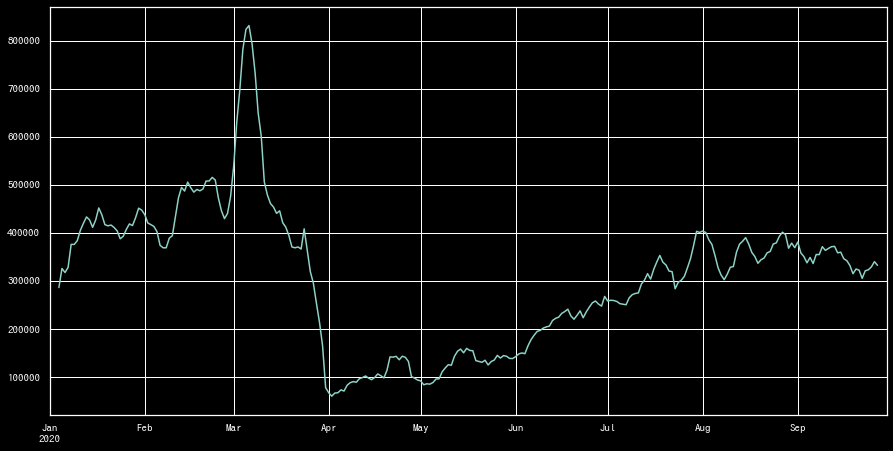

In [43]:
cli_dfs[4].plot()

In [77]:
start_test = date(2020, 9, 10)

### Set up news

In [79]:
npzfile1 = np.load('./sber_work_files/final/news4work.npz', allow_pickle=True)

month_ticks = npzfile1['month_ticks']
month_names = npzfile1['month_names']
fin_top_ts = npzfile1['fin_top_ts']
fin_top_names = npzfile1['fin_top_names']
sorted_topic_names_dict = npzfile1['sorted_topic_names_dict']

In [85]:
npzfile2 = np.load('./sber_work_files/final/context_w_labels.npz', allow_pickle=True)

context_ts = npzfile2['context_ts']
context_labels = npzfile2['context_labels']

In [89]:
context_names = list(fin_top_names) + list(context_labels)
print(context_names)

['Ковид', 'Белоруссия', 'Украина', 'Здоровье', 'Спорт', 'Погода', 'Религия', 'Авиация', 'Путешествия', 'Метро', 'Телевидение', 'Инвестиции', 'Правительство', 'Индекс доступности недвижимости, СПБ', 'Индекс доступности недвижимости, Россия', 'Ключевая ставка ЦБ', 'Инфляция в процентах годовых', 'Курс доллара, руб', 'Средние ставки по ипотеке', 'Средние ставки по ипотеке, перв. рынок', 'Средние ставки по ипотеке, втор. рынок', 'Индекс потребительских цен', 'Индекс потребительских цен, продовольствие', 'Индекс потребительских цен, не продукты', 'Индекс потребительских цен, услуги', 'Безработица', 'ВВП относительно предыдущего года', 'Относительный ВВП за вычетом сезонных вкладов', 'ВВП в млрд. руб.', 'Covid-19 в РФ, всего заражений', 'Covid-19 в РФ, новых заражений', 'Covid-19 в РФ, всего смертей', 'Covid-19 в РФ, новых смертей']


In [90]:
news_data = np.concatenate((fin_top_ts, context_ts), axis=0).T
print(news_data.shape)

news_df = pd.DataFrame(data=news_data[0:,0:], \
                     index=[basedate + timedelta(i) for i in range(news_data.shape[0])], \
                     columns=[context_names[i] for i in range(news_data.shape[1])])

news_df = news_df.fillna(0).asfreq('d')
news_df.head()

(274, 33)


,Ковид,Белоруссия,Украина,Здоровье,Спорт,Погода,Религия,Авиация,Путешествия,Метро,...,"Индекс потребительских цен, не продукты","Индекс потребительских цен, услуги",Безработица,ВВП относительно предыдущего года,Относительный ВВП за вычетом сезонных вкладов,ВВП в млрд. руб.,"Covid-19 в РФ, всего заражений","Covid-19 в РФ, новых заражений","Covid-19 в РФ, всего смертей","Covid-19 в РФ, новых смертей"
2020-01-01,0.0,1.000000,29.000000,22.000000,13.000000,15.000000,15.000000,16.000000,12.000000,0.0,...,100.230000,100.240000,0.0,2.000000,-0.100000,7787.000000,0.0,0.0,0.0,0.0
2020-01-02,0.0,1.616368,33.332759,21.785414,12.895061,15.888366,12.498857,14.649069,11.654498,0.0,...,100.209996,100.253019,0.0,2.097529,-0.135143,7845.390851,0.0,0.0,0.0,0.0
2020-01-03,0.0,2.122519,36.935551,21.594737,12.777482,16.671087,10.402857,13.557972,11.471783,0.0,...,100.190917,100.265449,0.0,2.190921,-0.168803,7902.265323,0.0,0.0,0.0,0.0
2020-01-04,0.0,2.518451,39.808375,21.427971,12.647264,17.348161,8.712000,12.726710,11.451854,0.0,...,100.172763,100.277291,0.0,2.280177,-0.200980,7957.623416,0.0,0.0,0.0,0.0
2020-01-05,0.0,2.804165,41.951232,21.285114,12.504407,17.919590,7.426285,12.155281,11.594711,0.0,...,100.155534,100.288545,0.0,2.365297,-0.231675,8011.465129,0.0,0.0,0.0,0.0


# ARIMAX

In [106]:
plot = False
rmse_matrix = np.zeros((len(group_names), len(context_names)))

for num_gr in range(len(group_names)):
    cli_df = cli_dfs[num_gr]
    cli_test = cli_df[cli_df.index.date >= start_test].copy()
    cli_train = cli_df[cli_df.index.date < start_test].copy()

    for topic_num, topic_name in enumerate(context_names):
        news_cur = news_df[str(topic_name)]
        news_test = news_cur[news_cur.index.date >= start_test].copy()
        news_train = news_cur[news_cur.index.date < start_test].copy()

        arimax = sm.tsa.statespace.SARIMAX(cli_train, \
                                        order=(7,1,7), \
                                        seasonal_order=(0,0,0,0), \
                                        exog = news_train, \
                                        freq='D', \
                                        enforce_stationarity=False, \
                                        enforce_invertibility=False).fit(disp=False)
        pred = arimax.predict(start_test, date(2020, 9, 30), exog=news_test)[1:]
        
        #print(f"Group {num_gr} Context {topic_name}")
        
        cur_pred = pd.DataFrame([pred, cli_test]).T.dropna()
        arr = np.array(cur_pred['predicted_mean']) - np.array(cur_pred['trend'])
        arr = arr**2
        rmse = np.sqrt(arr.sum())
        rmse_matrix[num_gr, topic_num] = rmse
        print(f"{num_gr * len(context_names) + topic_num + 1} / {len(context_names) * len(group_names)}")
    
        if plot:
            plt.clf()
            plt.plot(cli_df)
            plt.plot(pred)
            plt.title(f"Category: {group_names[num_gr]}    Context: {topic_name}")
            plt.ylabel("Spendings, rub")
            plt.xlabel("Date")
            plt.legend(["Real", "Predicted"])
            plt.savefig(f"./arimax_pics/{group_names[num_gr]}/{topic_name}.png")

0 / 462
1 / 462
2 / 462
3 / 462
4 / 462
5 / 462
6 / 462
7 / 462
8 / 462
9 / 462
10 / 462
11 / 462
12 / 462
13 / 462
14 / 462
15 / 462
16 / 462
17 / 462
18 / 462
19 / 462
20 / 462
21 / 462
22 / 462
23 / 462
24 / 462
25 / 462
26 / 462
27 / 462
28 / 462
29 / 462
30 / 462
31 / 462
32 / 462
33 / 462
34 / 462
35 / 462
36 / 462
37 / 462
38 / 462
39 / 462
40 / 462
41 / 462
42 / 462
43 / 462
44 / 462
45 / 462
46 / 462
47 / 462
48 / 462
49 / 462
50 / 462
51 / 462
52 / 462
53 / 462
54 / 462
55 / 462
56 / 462
57 / 462
58 / 462
59 / 462
60 / 462
61 / 462
62 / 462
63 / 462
64 / 462
65 / 462
66 / 462
67 / 462
68 / 462
69 / 462
70 / 462
71 / 462
72 / 462
73 / 462
74 / 462
75 / 462
76 / 462
77 / 462
78 / 462
79 / 462
80 / 462
81 / 462
82 / 462
83 / 462
84 / 462
85 / 462
86 / 462
87 / 462
88 / 462
89 / 462
90 / 462
91 / 462
92 / 462
93 / 462
94 / 462
95 / 462
96 / 462
97 / 462
98 / 462
99 / 462
100 / 462
101 / 462
102 / 462
103 / 462
104 / 462
105 / 462
106 / 462
107 / 462
108 / 462
109 / 462
110 / 462


In [123]:
print(rmse_matrix.T.shape)
#plt.plot(rmse_matrix.T)

(33, 14)


In [128]:
import csv

with open('rmse_matrix.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='"', quoting=csv.QUOTE_ALL)

    writer.writerow(["-"] + list(group_names))
    for i in range(rmse_matrix.shape[1]):
        writer.writerow([context_names[i]] + list(rmse_matrix[:,i]))